  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 0/200 | gen loss: 3.301376592757097 | disc_loss: 0.20147961363402891


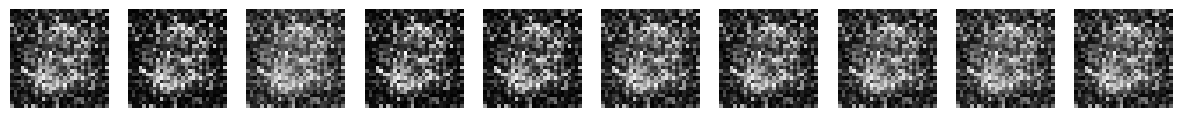

 20%|██        | 40/200 [11:32<44:51, 16.82s/it]

epoch: 40/200 | gen loss: 1.698521375020684 | disc_loss: 0.37799004203220926


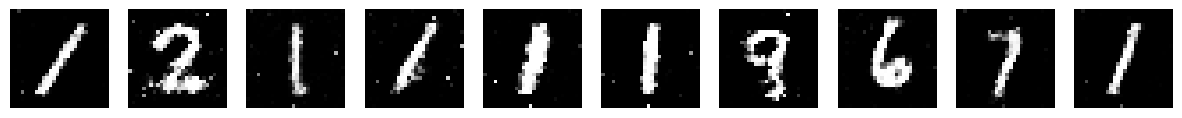

 40%|████      | 80/200 [22:47<34:04, 17.04s/it]

epoch: 80/200 | gen loss: 1.4547982940287478 | disc_loss: 0.44598974373294853


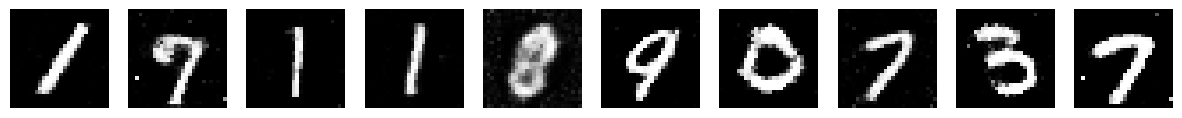

 60%|██████    | 120/200 [34:09<22:42, 17.03s/it]

epoch: 120/200 | gen loss: 1.4348082800409687 | disc_loss: 0.455485075235621


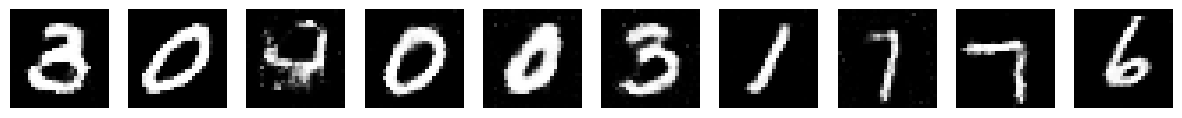

 80%|████████  | 160/200 [45:33<11:26, 17.16s/it]

epoch: 160/200 | gen loss: 1.4884380785895308 | disc_loss: 0.44247638261013195


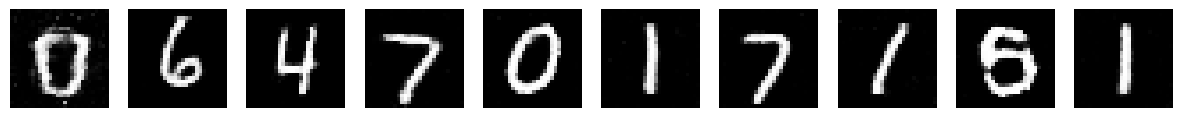

100%|██████████| 200/200 [56:53<00:00, 17.07s/it]


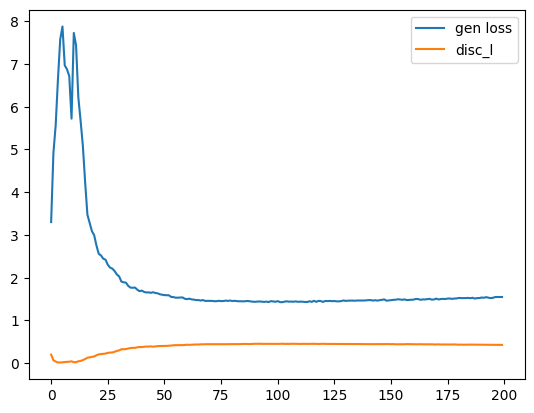

In [5]:
import torch
from torch import nn
import numpy as np
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm


class discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.disc = nn.Sequential(
                nn.Linear(784, 1024),
                nn.LeakyReLU(), # performs better than ReLU
                nn.Dropout(p=0.2),
                nn.Linear(1024, 512),
                nn.LeakyReLU(),
                nn.Dropout(p=0.2),
                nn.Linear(512, 256),
                nn.LeakyReLU(),
                nn.Dropout(p=0.2),
                nn.Linear(256, 1)
                )

    def forward(self, x):
        bs = x.shape[0]
        x = x.reshape(bs, -1)
        return self.disc(x)


class generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.gen = nn.Sequential(
                nn.Linear(latent_dim, 256),
                nn.LeakyReLU(),
                nn.Dropout(p=0.2),
                nn.Linear(256, 512),
                nn.LeakyReLU(),
                nn.Dropout(p=0.2),
                nn.Linear(512, 1024),
                nn.LeakyReLU(),
                nn.Dropout(p=0.2),
                nn.Linear(1024, 784),
                nn.Tanh()
                )

    def forward(self, noise):
        bs = noise.shape[0]
        ge = self.gen(noise)
        ge = ge.reshape(bs, 1, 28, 28)
        return ge


latent_dim = 100
batch_size = 64
device = "cuda" if torch.cuda.is_available() else "cpu"

gen_lr = 0.0001
disc_lr = 0.0001

gen = generator(latent_dim=latent_dim).to(device)
disc = discriminator().to(device)

gen_optim = optim.Adam(gen.parameters(), gen_lr)
disc_optim = optim.Adam(disc.parameters(), disc_lr)

t2i = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5, ), (0.5, ))
            ])

tr = MNIST("./data/", transform=t2i, download=True)
tl = DataLoader(tr, batch_size=batch_size, shuffle=True)

def train_gan(gen, disc, gen_optim, disc_optim, tl, epochs=200, device="cpu", plot_gen_freq=50, plot_loss_freq=20, num_gens=10):

    loss_fn = nn.BCEWithLogitsLoss() # as disc gives raw logit
    gen_losses, disc_losses = [], []

    for e in tqdm(range(epochs)):

        gen_epoch_losses = []
        disc_epoch_losses = []

        for im, _ in tl:
            # b, c, h, w
            bs = im.shape[0]
            im = im.to(device)

            #train disc
            noise = torch.randn(bs, latent_dim, device=device)

            gen_labels = torch.zeros(bs, 1, device=device)
            true_labels = torch.ones(bs, 1, device=device)

            gen_im = gen(noise).detach() # gradients won't go through into the generator

            real_disc_pred = disc(im)
            gen_disc_pred = disc(gen_im)

            real_loss = loss_fn(real_disc_pred, true_labels)
            fake_loss = loss_fn(gen_disc_pred, gen_labels)
            disc_loss = (real_loss + fake_loss) / 2
            disc_epoch_losses.append(disc_loss.item())

            disc_optim.zero_grad()
            disc_loss.backward()
            disc_optim.step()

            # train gen
            noise = torch.randn(bs, latent_dim, device=device)
            gen_im = gen(noise)
            gen_disc_pred = disc(gen_im)

            gen_loss = loss_fn(gen_disc_pred, true_labels)
            gen_epoch_losses.append(gen_loss.item())

            gen_optim.zero_grad()
            gen_loss.backward()
            gen_optim.step()

        gen_epoch_losses = np.mean(gen_epoch_losses)
        disc_epoch_losses = np.mean(disc_epoch_losses)

        if e % plot_loss_freq == 0:
            print(f"epoch: {e}/{epochs} | gen loss: {gen_epoch_losses} | disc_loss: {disc_epoch_losses}")

        gen_losses.append(gen_epoch_losses)
        disc_losses.append(disc_epoch_losses)

        if e % plot_gen_freq == 0:
            gen.eval()
            with torch.no_grad():
                noise_sample = torch.randn(num_gens, latent_dim, device=device)
                gen_imgs = gen(noise_sample).to("cpu")

                fig, ax = plt.subplots(1, num_gens, figsize=(15, 5))
                for i in range(num_gens):
                    img = (gen_imgs[i].squeeze() + 1) / 2 # b , 1, 28, 28
                    ax[i].imshow(img.numpy(), cmap="gray")
                    ax[i].set_axis_off()
                plt.show()
            gen.train()
    return gen, disc, gen_losses, disc_losses


gener, discr, gen_l, disc_l = train_gan(gen, disc, gen_optim, disc_optim, tl, epochs=200, device="cuda", plot_gen_freq=40, plot_loss_freq=40)


plt.plot(gen_l, label="gen loss")
plt.plot(disc_l, label="disc_l")
plt.legend()
plt.show()
